In [2]:
from util import setup_notebook
setup_notebook()
%load_ext autoreload
%autoreload 2

In [3]:
import altair as alt
from testmining import folders

In [4]:
from testmining import apfd

untreated = apfd.from_file('../output/square@okhttp/baseline/okhttp@untreated.csv').to_frame().reset_index().rename(columns={0: 'apfd'})
recently_failed = apfd.from_file('../output/square@okhttp/baseline/okhttp@recently-failed.csv').to_frame().reset_index().rename(columns={0: 'apfd'})

In [5]:
untreated.head()

,travisJobId,apfd
0,2685384,0.820144
1,2697352,0.701510
2,2820645,0.825784
3,2923196,0.826389
4,2923220,0.826389


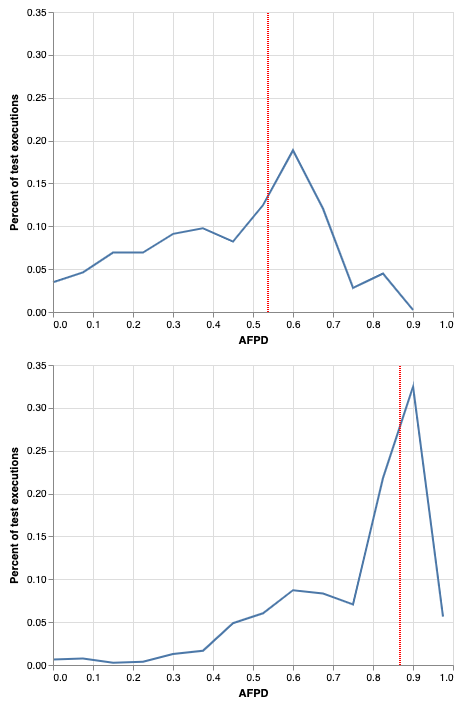

In [15]:
def plot(df):
    return alt.layer(area(), rule(), data=df).transform_window(a='median(apfd)', frame=[None, None])

def area():
    return alt.Chart().mark_line().encode(
        x=alt.X('apfd_bin:Q', scale=alt.Scale(domain=[0, 1.0]), title='AFPD'),
        y=alt.Y('binrelative:Q', title='Percent of test executions')
    ).transform_bin(**{'as': 'apfd_bin',
                       'field': 'apfd',
                       'bin': alt.BinParams(step=0.075)}
    ).transform_aggregate(
        bincount='count(travisJobId)',
        groupby=['apfd_bin']
    ).transform_window(
        binsum='sum(bincount)',
        frame=[None, None]
    ).transform_calculate(
        binrelative='datum.bincount / datum.binsum'
    )

def rule():
    return alt.Chart().mark_rule(color='red', strokeDash=[1,1]).encode(x='a:Q')

alt.vconcat(plot(untreated), plot(recently_failed)).resolve_scale(y='shared').configure_area(interpolate='basis')

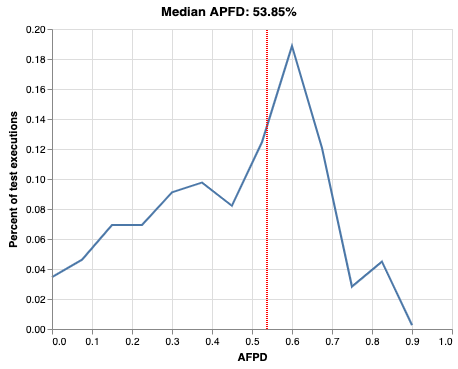

In [16]:
plot(untreated).configure_area(interpolate='basis').properties(title='Median APFD: %.2f%%' % (untreated['apfd'].median() * 100,))